# Practical Assesment Task #1: Colorizing Images with Generative Adversarial Networks
Técnicas Generativas y Aprendizaje por Refuerzo - Curso 2024/2025



## Import Dependencies and Set General Parameters

In [1]:
# %pip install tensorflow -q
%pip install scikit-image -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.layers import (
    Activation, AveragePooling2D, BatchNormalization, Conv2D, Dense,
    Dropout, Flatten, LeakyReLU, UpSampling2D)
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from time import time
from skimage.color import rgb2lab, lab2rgb
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential

# Enable memory growth for GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Constants
IMAGE_SIZE = 32
EPOCHS = 200 # Increase or decrease as appropriate
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 100

WORKDIR = "/GANWorkspace/"

# Create directories
Path(WORKDIR).mkdir(parents=True, exist_ok=True)
Path(f"{WORKDIR}/results").mkdir(parents=True, exist_ok=True)

## Define Dataset Loader

In [3]:
def generate_dataset(images, debug=False):
    """
    This function converts a list of RGB images to the LAB color space, and separates the L channel from the A and B channels.
    The images are normalized and reshaped to the appropriate dimensions for the model.

    Parameters:
    images (list): A list of RGB images
    debug (bool): If True, the function will display the original and converted images

    Returns:
    X (np.array): A numpy array of L channels of the images
    Y (np.array): A numpy array of A and B channels of the images
    """
    X = []
    Y = []

    for i in images:
        lab_image_array = rgb2lab(i / 255)  # Convert the image from RGB to LAB color space
        x = lab_image_array[:, :, 0]  # Get the L channel
        y = lab_image_array[:, :, 1:]  # Get the A and B channels
        y /= 128  # normalize

        if debug:  # If debug is True, display the original and converted images
            fig = plt.figure()
            fig.add_subplot(1, 2, 1)
            plt.imshow(i / 255)

            fig.add_subplot(1, 2, 2)
            plt.imshow(lab2rgb(np.dstack((x, y * 128))))
            plt.show()

        X.append(x.reshape(IMAGE_SIZE, IMAGE_SIZE, 1))  # Reshape the L channel and append to the list
        Y.append(y)  # Append the A and B channels to the list

    X = np.array(X, dtype=np.float32)  # Convert the list to a numpy array
    Y = np.array(Y, dtype=np.float32)  # Convert the list to a numpy array

    return X, Y


def load_data(force=False):
    """
    This function loads the CIFAR-10 dataset, processes it, and saves/loads the processed data to/from the disk.

    Parameters:
    force (bool): If True, the function will reprocess the data even if it already exists on the disk

    Returns:
    X_train, Y_train, X_test, Y_test (np.array): Numpy arrays of the training and testing data
    """
    is_saved_arrays_exist = os.path.isfile(os.path.join(WORKDIR, 'X_train.npy'))  # Check if the processed data already exists on the disk

    if not is_saved_arrays_exist or force:  # If the processed data does not exist or if force is True, process the data
        (train_images, _), (test_images, _) = cifar10.load_data()  # Load the CIFAR-10 dataset
        X_train, Y_train = generate_dataset(train_images)  # Process the training images
        X_test, Y_test = generate_dataset(test_images)  # Process the testing images
        print('Saving processed data to Drive')
        np.save(os.path.join(WORKDIR, 'X_train.npy'), X_train)  # Save the processed training data to the disk
        np.save(os.path.join(WORKDIR, 'Y_train.npy'), Y_train)  # Save the processed training data to the disk
        np.save(os.path.join(WORKDIR, 'X_test.npy'), X_test)  # Save the processed testing data to the disk
        np.save(os.path.join(WORKDIR, 'Y_test.npy'), Y_test)  # Save the processed testing data to the disk
    else:  # If the processed data exists and force is False, load the data from the disk
        print('Loading processed data from Drive')
        X_train = np.load(os.path.join(WORKDIR, 'X_train.npy'))  # Load the processed training data from the disk
        Y_train = np.load(os.path.join(WORKDIR, 'Y_train.npy'))  # Load the processed training data from the disk
        X_test = np.load(os.path.join(WORKDIR, 'X_test.npy'))  # Load the processed testing data from the disk
        Y_test = np.load(os.path.join(WORKDIR, 'Y_test.npy'))  # Load the processed testing data from the disk

    return X_train, Y_train, X_test, Y_test

## Load Dataset

In [4]:
# Load the processed training and testing data
X_train, Y_train, X_test, Y_test = load_data()

# Create TensorFlow datasets from the training and testing data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

# Shuffle the training dataset and batch both datasets
# SHUFFLE_BUFFER_SIZE determines the randomness of the shuffling
# BATCH_SIZE determines the number of samples that will be propagated through the network at once
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

170498071/170498071 [==============================] - 21s 0us/step
Saving processed data to Drive


## Define Generator Model

In [ ]:
def build_generator_model():
    """
    This function builds the generator model for the GAN. The generator is responsible for generating new, fake images.
    It uses a series of Conv2D, BatchNormalization, and UpSampling2D layers.

    Returns:
    model (Sequential): The generator model
    """
    model = Sequential()

    #downsampling
    model.add(Conv2D(64, (3,3), strides=2, padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(128, (3,3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(256, (3,3), strides=2, padding='same'))  #4x4
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(512, (3,3), strides=2, padding='same'))  #4x4
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    #upsampling
    model.add(UpSampling2D(size=(2,2)))  #4x4 → 8x8
    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(UpSampling2D(size=(2,2)))  #4x4 → 8x8
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(UpSampling2D(size=(2,2)))  #8x8 → 16x16
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(UpSampling2D(size=(2,2)))  #16x16 → 32x32
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    #salida
    model.add(Conv2D(2, (3,3), padding='same')) 
    model.add(Activation('tanh'))  # Salida en [-1,1]

    return model

## Define Discriminator Model

In [ ]:
def build_discriminator_model():
    """
    This function builds the discriminator model for the GAN. The discriminator is responsible for distinguishing real images from fake ones.
    It is recommended to use a series of Conv2D, Dropout, AveragePooling2D, Flatten, Dense, LeakyReLU, BatchNormalization, and Activation layers to create the model.

    Returns:
    model (Sequential): The discriminator model
    """

    model = Sequential()

    # conv
    model.add(Conv2D(64, (3,3), strides=2, padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 2)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3,3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    # pooling
    model.add(AveragePooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # salida
    model.add(Dense(1, activation='sigmoid'))  # Salida en [0,1] (real o falsa)


    return model

## Define Generator and Discriminator Loss Functions

In [ ]:
# Define the weight of the GAN loss
gan_loss_weight = 1

# Define the regularization parameter for the generator's L2 loss
l2_lambda = 150

# Define the loss function for the discriminator
# Binary Cross Entropy is used as the loss function since we are dealing with a binary classification problem (real vs fake images)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    """
    This function calculates the total loss for the discriminator.

    Parameters:
    disc_real_output (Tensor): The discriminator's prediction on the real images
    disc_generated_output (Tensor): The discriminator's prediction on the generated (fake) images

    Returns:
    total_disc_loss (Tensor): The total loss for the discriminator
    """

    # Cross entropy loss for real images (label 1 = real)
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)

    # Cross entropy loss for generated (fake) images (label 0 = fake)
    fake_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)

    # Total loss for the discriminator
    total_disc_loss = real_loss + fake_loss

    return total_disc_loss


def generator_loss(disc_generated_output, gen_output, target):
    """
    This function calculates the total loss for the generator.

    Parameters:
    disc_generated_output (Tensor): The discriminator's prediction on the generated (fake) images
    gen_output (Tensor): The generated (fake) images
    target (Tensor): The real images

    Returns:
    total_gen_loss (Tensor): The total loss for the generator
    gan_loss (Tensor): The GAN loss for the generator
    l2_loss (Tensor): The L2 loss for the generator
    """

    # GAN loss 
    gan_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)

    # L2 Loss
    l2_loss = tf.reduce_mean(tf.square(target - gen_output))

    # Total Generator Loss (GAN loss ponderada + L2 regularización)
    total_gen_loss = gan_loss_weight * gan_loss + l2_lambda * l2_loss

    return total_gen_loss, gan_loss, l2_loss


## Build Generator and Discriminator Models

In [8]:
# Instantiate the generator and discriminator models
generator = build_generator_model()
discriminator = build_discriminator_model()

# Print out the model summaries
generator.summary()
discriminator.summary()

# Define the optimizers for the generator and discriminator
# Adam optimizer is used with a learning rate of 2e-4 and beta_1 (the exponential decay rate for the first moment estimates) of 0.5
# It is recommended to experiment with different values for the learning rate. Beta_1 value of 0.5 is recommended for GANs
# It is possible that the optimal learning rate for the generator and discriminator is different from each other
gen_learning_rate = 2e-4
gene_beta_1 = 0.5

disc_learning_rate = 2e-4
disc_beta_1 = 0.5

generator_optimizer = tf.keras.optimizers.Adam(gen_learning_rate, beta_1=gene_beta_1)
discriminator_optimizer = tf.keras.optimizers.Adam(disc_learning_rate, beta_1=disc_beta_1)

# Define the directory for storing the training checkpoints
checkpoint_dir = os.path.join(WORKDIR, 'training-checkpoints')
# Define the prefix for the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# Create a checkpoint object which will be used to save and load the models and optimizers
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
# Create a manager for the checkpoint object, which will be responsible for saving and loading the checkpoints
# max_to_keep parameter is set to 3, meaning that only the 3 most recent checkpoints will be kept
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0

In [9]:
# Define the directory and file for storing the TensorBoard summary logs
summary_log_file = os.path.join(
    WORKDIR, 'tf-summary', datetime.now().strftime("%Y%m%d-%H%M%S"))
# Create a summary writer for writing the summary logs
summary_writer = tf.summary.create_file_writer(summary_log_file)

@tf.function
def train_step(input_image, target, epoch):
    """
    This function performs one training step for the generator and discriminator.

    Parameters:
    input_image (Tensor): The input image
    target (Tensor): The target image
    epoch (int): The current epoch number

    Returns:
    gen_total_loss (Tensor): The total loss for the generator
    disc_loss (Tensor): The loss for the discriminator
    """

    # Open a GradientTape context for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_total_loss = 0  # Initialize the total loss for the generator
        gen_gan_loss = 0  # Initialize the GAN loss for the generator
        gen_l2_loss = 0  # Initialize the L2 loss for the generator
        disc_loss = 0  # Initialize the loss for the discriminator

        # Generate an image using the generator
        # (remember to set training=True, since during training time BatchNormalization layers are applied using the batch mean and variance)
        gen_output = generator(input_image, training=True)

        # Get the discriminator's predictions on the real and generated images
        # (remember to set training=True, since during training time BatchNormalization layers are applied using the batch mean and variance)
        disc_real_output = discriminator(target, training=True)
        disc_generated_output = discriminator(gen_output, training=True)

        # Calculate the losses for the generator and discriminator
        gen_total_loss, gen_gan_loss, gen_l2_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Calculate the gradients of the generator's and discriminator's losses with respect to the trainable variables of each model
    # Use the gradient() method of the GradientTape object of each model to calculate the gradients of the losses with respect to the trainable variables of the corresponding model
    gen_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the gradients to the model's trainable variables
    # Use the apply_gradients() method of the optimizer object to apply the gradients
    # The apply_gradients() method takes a list of (gradient, variable) pairs
    # zip() function can be used to iterate over two lists simultaneously (i.e., the gradients and the model's trainable variables)
    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    # Write the losses to the summary logs
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l2_loss', gen_l2_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

    return gen_total_loss, disc_loss


In [10]:
# The checkpoint manager will load the latest checkpoint if it exists
# This will be used to resume training if the training process was interrupted
# If no checkpoint exists, the models will be initialized from scratch

# Restore the latest checkpoint using the checkpoint manager
checkpoint.restore(manager.latest_checkpoint)

# If a checkpoint was found and restored, print a message indicating the checkpoint file
if manager.latest_checkpoint:
    print('Restored from {}'.format(manager.latest_checkpoint))

# If no checkpoint was found, print a message indicating that the models are being initialized from scratch
else:
    print('Initializing from scratch')

Initializing from scratch


In [11]:
dloss = []
gloss = []
# Loop over the epochs
for e in tqdm(range(EPOCHS)):
    # Record the start time of the epoch
    start_time = time()

    gen_loss_total = 0  # Initialize the total loss for the generator
    disc_loss_total = 0  # Initialize the total loss for the discriminator

    # Loop over the training dataset
    for input_image, target in train_dataset:
        # Perform one training step and get the generator and discriminator losses
        gen_loss, disc_loss = train_step(input_image, target, e)
        
        dloss.append(disc_loss)
        gloss.append(gen_loss)

        # Add the losses to the total losses
        gen_loss_total += gen_loss
        disc_loss_total += disc_loss

    # Calculate the time taken for the epoch
    time_taken = time() - start_time

    # If the epoch number is a multiple of 10, save a checkpoint
    if (e + 1) % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    # Print the epoch number, average generator loss, average discriminator loss, and time taken
    print(f'Epoch {e + 1}: gen loss: {gen_loss_total / len(train_dataset)}, '
          f'disc loss: {disc_loss_total / len(train_dataset)}, time: {time_taken:.2f}s')


  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\mgonz\anaconda3\envs\py39-tensorflowGPU\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
  0%|          | 1/200 [01:39<5:29:00, 99.20s/it]

Epoch 1: gen loss: 3.413093090057373, disc loss: 1.6396682262420654, time: 99.19s


  1%|          | 2/200 [02:04<3:03:11, 55.51s/it]

Epoch 2: gen loss: 2.358445644378662, disc loss: 1.514689326286316, time: 24.93s


  2%|▏         | 3/200 [02:29<2:16:33, 41.59s/it]

Epoch 3: gen loss: 2.2549192905426025, disc loss: 1.4676787853240967, time: 25.03s


  2%|▏         | 4/200 [02:54<1:55:30, 35.36s/it]

Epoch 4: gen loss: 2.1978440284729004, disc loss: 1.437313199043274, time: 25.78s


  2%|▎         | 5/200 [03:21<1:44:09, 32.05s/it]

Epoch 5: gen loss: 2.1579253673553467, disc loss: 1.417316198348999, time: 26.18s


  3%|▎         | 6/200 [03:47<1:37:22, 30.12s/it]

Epoch 6: gen loss: 2.131099224090576, disc loss: 1.4069501161575317, time: 26.37s


  4%|▎         | 7/200 [04:12<1:31:39, 28.50s/it]

Epoch 7: gen loss: 2.1033473014831543, disc loss: 1.4000840187072754, time: 25.16s


  4%|▍         | 8/200 [04:57<1:48:07, 33.79s/it]

Epoch 8: gen loss: 2.0845131874084473, disc loss: 1.3946127891540527, time: 45.13s


  4%|▍         | 9/200 [05:32<1:48:54, 34.21s/it]

Epoch 9: gen loss: 2.0630404949188232, disc loss: 1.3912723064422607, time: 35.13s


  5%|▌         | 10/200 [05:58<1:39:57, 31.57s/it]

Epoch 10: gen loss: 2.0403599739074707, disc loss: 1.3896963596343994, time: 24.71s


  6%|▌         | 11/200 [06:22<1:32:01, 29.21s/it]

Epoch 11: gen loss: 2.0181565284729004, disc loss: 1.3884544372558594, time: 23.87s


  6%|▌         | 12/200 [06:47<1:27:36, 27.96s/it]

Epoch 12: gen loss: 1.9873651266098022, disc loss: 1.3881176710128784, time: 25.10s


  6%|▋         | 13/200 [07:12<1:24:09, 27.00s/it]

Epoch 13: gen loss: 1.9597923755645752, disc loss: 1.3875446319580078, time: 24.80s


  7%|▋         | 14/200 [07:36<1:20:56, 26.11s/it]

Epoch 14: gen loss: 1.923513412475586, disc loss: 1.3880771398544312, time: 24.05s


  8%|▊         | 15/200 [08:02<1:20:30, 26.11s/it]

Epoch 15: gen loss: 1.87958824634552, disc loss: 1.3873735666275024, time: 26.11s


  8%|▊         | 16/200 [08:28<1:19:41, 25.99s/it]

Epoch 16: gen loss: 1.8426307439804077, disc loss: 1.3873738050460815, time: 25.69s


  8%|▊         | 17/200 [08:52<1:18:04, 25.60s/it]

Epoch 17: gen loss: 1.7931888103485107, disc loss: 1.3876190185546875, time: 24.70s


  9%|▉         | 18/200 [09:19<1:18:38, 25.92s/it]

Epoch 18: gen loss: 1.7463321685791016, disc loss: 1.3874764442443848, time: 26.68s


 10%|▉         | 19/200 [09:45<1:18:28, 26.01s/it]

Epoch 19: gen loss: 1.7024589776992798, disc loss: 1.3877955675125122, time: 26.22s


 10%|█         | 20/200 [10:12<1:18:28, 26.16s/it]

Epoch 20: gen loss: 1.6632161140441895, disc loss: 1.3874515295028687, time: 25.66s


 10%|█         | 21/200 [10:38<1:17:48, 26.08s/it]

Epoch 21: gen loss: 1.626823902130127, disc loss: 1.3874359130859375, time: 25.90s


 11%|█         | 22/200 [11:03<1:16:45, 25.88s/it]

Epoch 22: gen loss: 1.5955262184143066, disc loss: 1.3876559734344482, time: 25.40s


 12%|█▏        | 23/200 [11:29<1:16:32, 25.95s/it]

Epoch 23: gen loss: 1.5599924325942993, disc loss: 1.3873915672302246, time: 26.12s


 12%|█▏        | 24/200 [11:57<1:17:31, 26.43s/it]

Epoch 24: gen loss: 1.5310673713684082, disc loss: 1.3876076936721802, time: 27.56s


 12%|█▎        | 25/200 [12:24<1:17:39, 26.62s/it]

Epoch 25: gen loss: 1.5093302726745605, disc loss: 1.3876477479934692, time: 27.07s


 13%|█▎        | 26/200 [12:54<1:20:12, 27.66s/it]

Epoch 26: gen loss: 1.4853006601333618, disc loss: 1.3876997232437134, time: 30.07s


 14%|█▎        | 27/200 [13:38<1:33:42, 32.50s/it]

Epoch 27: gen loss: 1.463437795639038, disc loss: 1.3873072862625122, time: 43.79s


 14%|█▍        | 28/200 [14:03<1:27:17, 30.45s/it]

Epoch 28: gen loss: 1.4432296752929688, disc loss: 1.387666940689087, time: 25.68s


 14%|█▍        | 29/200 [14:29<1:22:18, 28.88s/it]

Epoch 29: gen loss: 1.4223365783691406, disc loss: 1.387352705001831, time: 25.22s


 15%|█▌        | 30/200 [14:55<1:19:46, 28.15s/it]

Epoch 30: gen loss: 1.4046984910964966, disc loss: 1.387581467628479, time: 25.58s


 16%|█▌        | 31/200 [15:21<1:17:10, 27.40s/it]

Epoch 31: gen loss: 1.3865145444869995, disc loss: 1.387765884399414, time: 25.64s


 16%|█▌        | 32/200 [15:45<1:13:41, 26.32s/it]

Epoch 32: gen loss: 1.377002477645874, disc loss: 1.3878248929977417, time: 23.79s


 16%|█▋        | 33/200 [16:09<1:11:34, 25.72s/it]

Epoch 33: gen loss: 1.3658798933029175, disc loss: 1.3872499465942383, time: 24.31s


 17%|█▋        | 34/200 [16:33<1:10:08, 25.35s/it]

Epoch 34: gen loss: 1.3517651557922363, disc loss: 1.3875484466552734, time: 24.49s


 18%|█▊        | 35/200 [16:58<1:08:48, 25.02s/it]

Epoch 35: gen loss: 1.3370139598846436, disc loss: 1.3876192569732666, time: 24.25s


 18%|█▊        | 36/200 [17:22<1:08:08, 24.93s/it]

Epoch 36: gen loss: 1.32930326461792, disc loss: 1.387194037437439, time: 24.70s


 18%|█▊        | 37/200 [17:48<1:08:30, 25.22s/it]

Epoch 37: gen loss: 1.3130332231521606, disc loss: 1.3878165483474731, time: 25.90s


 19%|█▉        | 38/200 [18:14<1:08:39, 25.43s/it]

Epoch 38: gen loss: 1.3029704093933105, disc loss: 1.3876707553863525, time: 25.91s


 20%|█▉        | 39/200 [18:41<1:09:11, 25.79s/it]

Epoch 39: gen loss: 1.2967820167541504, disc loss: 1.387489914894104, time: 26.62s


 20%|██        | 40/200 [19:08<1:09:50, 26.19s/it]

Epoch 40: gen loss: 1.2882457971572876, disc loss: 1.3873639106750488, time: 26.30s


 20%|██        | 41/200 [19:33<1:08:55, 26.01s/it]

Epoch 41: gen loss: 1.2774901390075684, disc loss: 1.3875778913497925, time: 25.57s


 21%|██        | 42/200 [19:59<1:08:13, 25.91s/it]

Epoch 42: gen loss: 1.2720597982406616, disc loss: 1.3873237371444702, time: 25.68s


 22%|██▏       | 43/200 [20:24<1:07:06, 25.65s/it]

Epoch 43: gen loss: 1.2616666555404663, disc loss: 1.3876171112060547, time: 25.03s


 22%|██▏       | 44/200 [20:50<1:06:48, 25.69s/it]

Epoch 44: gen loss: 1.2551839351654053, disc loss: 1.3875510692596436, time: 25.80s


 22%|██▎       | 45/200 [21:14<1:05:17, 25.27s/it]

Epoch 45: gen loss: 1.246617078781128, disc loss: 1.3875001668930054, time: 24.29s


 23%|██▎       | 46/200 [21:39<1:04:16, 25.04s/it]

Epoch 46: gen loss: 1.2409189939498901, disc loss: 1.38756263256073, time: 24.50s


 24%|██▎       | 47/200 [22:03<1:03:32, 24.92s/it]

Epoch 47: gen loss: 1.235670566558838, disc loss: 1.387277603149414, time: 24.63s


 24%|██▍       | 48/200 [22:28<1:02:38, 24.73s/it]

Epoch 48: gen loss: 1.229242205619812, disc loss: 1.3879358768463135, time: 24.28s


 24%|██▍       | 49/200 [22:52<1:01:47, 24.55s/it]

Epoch 49: gen loss: 1.2219622135162354, disc loss: 1.387164831161499, time: 24.14s


 25%|██▌       | 50/200 [23:18<1:02:51, 25.14s/it]

Epoch 50: gen loss: 1.2163320779800415, disc loss: 1.3876845836639404, time: 25.64s


 26%|██▌       | 51/200 [23:43<1:02:19, 25.10s/it]

Epoch 51: gen loss: 1.2090708017349243, disc loss: 1.3874447345733643, time: 24.99s


 26%|██▌       | 52/200 [24:09<1:02:39, 25.40s/it]

Epoch 52: gen loss: 1.2079864740371704, disc loss: 1.3870124816894531, time: 26.12s


 26%|██▋       | 53/200 [24:37<1:03:33, 25.94s/it]

Epoch 53: gen loss: 1.2047280073165894, disc loss: 1.3878880739212036, time: 27.19s


 27%|██▋       | 54/200 [25:03<1:03:07, 25.94s/it]

Epoch 54: gen loss: 1.1975044012069702, disc loss: 1.3874130249023438, time: 25.94s


 28%|██▊       | 55/200 [25:41<1:11:26, 29.56s/it]

Epoch 55: gen loss: 1.1894705295562744, disc loss: 1.38728666305542, time: 38.00s


 28%|██▊       | 56/200 [26:08<1:09:17, 28.87s/it]

Epoch 56: gen loss: 1.1852898597717285, disc loss: 1.3873628377914429, time: 27.26s


 28%|██▊       | 57/200 [26:34<1:06:38, 27.96s/it]

Epoch 57: gen loss: 1.1835956573486328, disc loss: 1.3869675397872925, time: 25.84s


 29%|██▉       | 58/200 [26:59<1:04:12, 27.13s/it]

Epoch 58: gen loss: 1.1776729822158813, disc loss: 1.3876523971557617, time: 25.18s


 30%|██▉       | 59/200 [27:29<1:06:14, 28.19s/it]

Epoch 59: gen loss: 1.1705141067504883, disc loss: 1.3874061107635498, time: 30.66s


 30%|███       | 60/200 [28:02<1:09:03, 29.60s/it]

Epoch 60: gen loss: 1.1682988405227661, disc loss: 1.3875536918640137, time: 32.14s


 30%|███       | 61/200 [28:28<1:05:35, 28.31s/it]

Epoch 61: gen loss: 1.165376901626587, disc loss: 1.3874850273132324, time: 25.31s


 31%|███       | 62/200 [28:52<1:02:30, 27.18s/it]

Epoch 62: gen loss: 1.1603577136993408, disc loss: 1.3874808549880981, time: 24.53s


 32%|███▏      | 63/200 [29:17<1:00:10, 26.35s/it]

Epoch 63: gen loss: 1.1614081859588623, disc loss: 1.3875629901885986, time: 24.42s


 32%|███▏      | 64/200 [29:42<58:58, 26.02s/it]  

Epoch 64: gen loss: 1.1527869701385498, disc loss: 1.3874388933181763, time: 25.25s


 32%|███▎      | 65/200 [30:06<56:58, 25.32s/it]

Epoch 65: gen loss: 1.1514673233032227, disc loss: 1.387414813041687, time: 23.69s


 33%|███▎      | 66/200 [30:30<56:04, 25.11s/it]

Epoch 66: gen loss: 1.1456493139266968, disc loss: 1.387556552886963, time: 24.62s


 34%|███▎      | 67/200 [30:59<58:17, 26.30s/it]

Epoch 67: gen loss: 1.1422547101974487, disc loss: 1.387332797050476, time: 29.07s


 34%|███▍      | 68/200 [31:26<58:14, 26.47s/it]

Epoch 68: gen loss: 1.1396775245666504, disc loss: 1.3876312971115112, time: 26.87s


 34%|███▍      | 69/200 [32:06<1:06:19, 30.38s/it]

Epoch 69: gen loss: 1.135156512260437, disc loss: 1.3877042531967163, time: 39.50s


 35%|███▌      | 70/200 [32:43<1:10:34, 32.57s/it]

Epoch 70: gen loss: 1.1329823732376099, disc loss: 1.3871976137161255, time: 36.65s


 36%|███▌      | 71/200 [33:10<1:05:56, 30.67s/it]

Epoch 71: gen loss: 1.130348563194275, disc loss: 1.3876609802246094, time: 26.23s


 36%|███▌      | 72/200 [33:35<1:02:15, 29.19s/it]

Epoch 72: gen loss: 1.1284122467041016, disc loss: 1.3873058557510376, time: 25.72s


 36%|███▋      | 73/200 [34:02<59:57, 28.33s/it]  

Epoch 73: gen loss: 1.1269830465316772, disc loss: 1.3874092102050781, time: 26.32s


 37%|███▋      | 74/200 [34:26<56:48, 27.05s/it]

Epoch 74: gen loss: 1.1236765384674072, disc loss: 1.38742995262146, time: 24.06s


 38%|███▊      | 75/200 [34:50<54:49, 26.32s/it]

Epoch 75: gen loss: 1.1198595762252808, disc loss: 1.3873958587646484, time: 24.61s


 38%|███▊      | 76/200 [35:15<53:15, 25.77s/it]

Epoch 76: gen loss: 1.1158578395843506, disc loss: 1.3873200416564941, time: 24.50s


 38%|███▊      | 77/200 [35:39<51:58, 25.36s/it]

Epoch 77: gen loss: 1.1121610403060913, disc loss: 1.387452244758606, time: 24.39s


 39%|███▉      | 78/200 [36:03<50:42, 24.94s/it]

Epoch 78: gen loss: 1.110312581062317, disc loss: 1.387373447418213, time: 23.97s


 40%|███▉      | 79/200 [36:27<49:33, 24.58s/it]

Epoch 79: gen loss: 1.1083647012710571, disc loss: 1.3872871398925781, time: 23.72s


 40%|████      | 80/200 [36:52<49:37, 24.82s/it]

Epoch 80: gen loss: 1.103228211402893, disc loss: 1.3873746395111084, time: 24.03s


 40%|████      | 81/200 [37:20<51:12, 25.82s/it]

Epoch 81: gen loss: 1.1028962135314941, disc loss: 1.3876525163650513, time: 28.15s


 41%|████      | 82/200 [37:50<52:42, 26.80s/it]

Epoch 82: gen loss: 1.103411078453064, disc loss: 1.3873144388198853, time: 29.09s


 42%|████▏     | 83/200 [38:14<50:45, 26.03s/it]

Epoch 83: gen loss: 1.096937656402588, disc loss: 1.3873398303985596, time: 24.24s


 42%|████▏     | 84/200 [38:38<49:10, 25.43s/it]

Epoch 84: gen loss: 1.0968858003616333, disc loss: 1.3873306512832642, time: 24.03s


 42%|████▎     | 85/200 [39:01<47:38, 24.86s/it]

Epoch 85: gen loss: 1.0937275886535645, disc loss: 1.3871688842773438, time: 23.52s


 43%|████▎     | 86/200 [39:25<46:26, 24.44s/it]

Epoch 86: gen loss: 1.092160940170288, disc loss: 1.387903094291687, time: 23.46s


 44%|████▎     | 87/200 [39:48<45:31, 24.17s/it]

Epoch 87: gen loss: 1.08815598487854, disc loss: 1.3872159719467163, time: 23.53s


 44%|████▍     | 88/200 [40:12<44:49, 24.01s/it]

Epoch 88: gen loss: 1.0865918397903442, disc loss: 1.3873287439346313, time: 23.64s


 44%|████▍     | 89/200 [40:36<44:26, 24.03s/it]

Epoch 89: gen loss: 1.0866775512695312, disc loss: 1.3873296976089478, time: 24.06s


 45%|████▌     | 90/200 [41:01<44:37, 24.34s/it]

Epoch 90: gen loss: 1.0824263095855713, disc loss: 1.3870067596435547, time: 24.29s


 46%|████▌     | 91/200 [41:25<44:02, 24.24s/it]

Epoch 91: gen loss: 1.0796480178833008, disc loss: 1.3877514600753784, time: 24.00s


 46%|████▌     | 92/200 [41:52<44:54, 24.95s/it]

Epoch 92: gen loss: 1.0802358388900757, disc loss: 1.3873322010040283, time: 26.59s


 46%|████▋     | 93/200 [42:16<44:20, 24.86s/it]

Epoch 93: gen loss: 1.07838773727417, disc loss: 1.3873355388641357, time: 24.66s


 47%|████▋     | 94/200 [42:42<44:13, 25.03s/it]

Epoch 94: gen loss: 1.0761245489120483, disc loss: 1.3872267007827759, time: 25.42s


 48%|████▊     | 95/200 [43:06<43:25, 24.81s/it]

Epoch 95: gen loss: 1.074884057044983, disc loss: 1.3877347707748413, time: 24.30s


 48%|████▊     | 96/200 [43:32<43:35, 25.15s/it]

Epoch 96: gen loss: 1.0712571144104004, disc loss: 1.3875318765640259, time: 25.94s


 48%|████▊     | 97/200 [43:57<42:54, 25.00s/it]

Epoch 97: gen loss: 1.0699232816696167, disc loss: 1.387305498123169, time: 24.65s


 49%|████▉     | 98/200 [44:21<42:16, 24.86s/it]

Epoch 98: gen loss: 1.0695370435714722, disc loss: 1.3872164487838745, time: 24.55s


 50%|████▉     | 99/200 [44:53<45:20, 26.94s/it]

Epoch 99: gen loss: 1.068701982498169, disc loss: 1.3877421617507935, time: 31.78s


 50%|█████     | 100/200 [45:21<45:15, 27.15s/it]

Epoch 100: gen loss: 1.0637372732162476, disc loss: 1.387374997138977, time: 26.68s


 50%|█████     | 101/200 [45:47<44:24, 26.91s/it]

Epoch 101: gen loss: 1.064587950706482, disc loss: 1.3872873783111572, time: 26.35s


 51%|█████     | 102/200 [46:11<42:30, 26.03s/it]

Epoch 102: gen loss: 1.0621694326400757, disc loss: 1.3873165845870972, time: 23.97s


 52%|█████▏    | 103/200 [46:37<41:53, 25.91s/it]

Epoch 103: gen loss: 1.0589536428451538, disc loss: 1.3871206045150757, time: 25.63s


 52%|█████▏    | 104/200 [47:03<41:45, 26.10s/it]

Epoch 104: gen loss: 1.0595461130142212, disc loss: 1.3872326612472534, time: 26.53s


 52%|█████▎    | 105/200 [47:29<41:15, 26.06s/it]

Epoch 105: gen loss: 1.0575711727142334, disc loss: 1.3874748945236206, time: 25.97s


 53%|█████▎    | 106/200 [47:53<39:59, 25.53s/it]

Epoch 106: gen loss: 1.0584001541137695, disc loss: 1.3872790336608887, time: 24.28s


 54%|█████▎    | 107/200 [48:19<39:47, 25.67s/it]

Epoch 107: gen loss: 1.0558029413223267, disc loss: 1.3874452114105225, time: 26.02s


 54%|█████▍    | 108/200 [48:43<38:38, 25.20s/it]

Epoch 108: gen loss: 1.0531378984451294, disc loss: 1.387154221534729, time: 24.10s


 55%|█████▍    | 109/200 [49:08<38:04, 25.11s/it]

Epoch 109: gen loss: 1.052506685256958, disc loss: 1.3872443437576294, time: 24.89s


 55%|█████▌    | 110/200 [49:35<38:19, 25.55s/it]

Epoch 110: gen loss: 1.051032304763794, disc loss: 1.3870915174484253, time: 25.93s


 56%|█████▌    | 111/200 [50:00<37:30, 25.29s/it]

Epoch 111: gen loss: 1.050321340560913, disc loss: 1.3872971534729004, time: 24.67s


 56%|█████▌    | 112/200 [50:26<37:38, 25.67s/it]

Epoch 112: gen loss: 1.0462394952774048, disc loss: 1.387264609336853, time: 26.55s


 56%|█████▋    | 113/200 [50:51<37:02, 25.55s/it]

Epoch 113: gen loss: 1.0453194379806519, disc loss: 1.3872737884521484, time: 25.26s


 57%|█████▋    | 114/200 [51:17<36:48, 25.68s/it]

Epoch 114: gen loss: 1.0444084405899048, disc loss: 1.387556552886963, time: 25.99s


 57%|█████▊    | 115/200 [51:43<36:12, 25.56s/it]

Epoch 115: gen loss: 1.041986346244812, disc loss: 1.3871252536773682, time: 25.28s


 58%|█████▊    | 116/200 [52:09<36:05, 25.78s/it]

Epoch 116: gen loss: 1.0435587167739868, disc loss: 1.3872835636138916, time: 26.28s


 58%|█████▊    | 117/200 [52:35<35:40, 25.79s/it]

Epoch 117: gen loss: 1.041023850440979, disc loss: 1.3871448040008545, time: 25.83s


 59%|█████▉    | 118/200 [53:01<35:27, 25.94s/it]

Epoch 118: gen loss: 1.038765788078308, disc loss: 1.3871978521347046, time: 26.29s


 60%|█████▉    | 119/200 [53:26<34:34, 25.61s/it]

Epoch 119: gen loss: 1.0364391803741455, disc loss: 1.3874528408050537, time: 24.85s


 60%|██████    | 120/200 [53:53<34:40, 26.01s/it]

Epoch 120: gen loss: 1.0347284078598022, disc loss: 1.387618064880371, time: 26.13s


 60%|██████    | 121/200 [54:20<34:31, 26.23s/it]

Epoch 121: gen loss: 1.0368907451629639, disc loss: 1.3873502016067505, time: 26.74s


 61%|██████    | 122/200 [54:46<34:18, 26.38s/it]

Epoch 122: gen loss: 1.0325911045074463, disc loss: 1.3874001502990723, time: 26.75s


 62%|██████▏   | 123/200 [55:14<34:18, 26.74s/it]

Epoch 123: gen loss: 1.0317946672439575, disc loss: 1.3871556520462036, time: 27.56s


 62%|██████▏   | 124/200 [55:41<34:06, 26.93s/it]

Epoch 124: gen loss: 1.035804271697998, disc loss: 1.387241005897522, time: 27.39s


 62%|██████▎   | 125/200 [56:08<33:35, 26.87s/it]

Epoch 125: gen loss: 1.0308823585510254, disc loss: 1.3872320652008057, time: 26.71s


 63%|██████▎   | 126/200 [56:35<33:16, 26.99s/it]

Epoch 126: gen loss: 1.0290409326553345, disc loss: 1.3873393535614014, time: 27.26s


 64%|██████▎   | 127/200 [57:02<32:35, 26.79s/it]

Epoch 127: gen loss: 1.0293009281158447, disc loss: 1.3874285221099854, time: 26.34s


 64%|██████▍   | 128/200 [57:29<32:29, 27.07s/it]

Epoch 128: gen loss: 1.0268373489379883, disc loss: 1.387548565864563, time: 27.73s


 64%|██████▍   | 129/200 [57:55<31:33, 26.67s/it]

Epoch 129: gen loss: 1.0290031433105469, disc loss: 1.3872833251953125, time: 25.73s


 65%|██████▌   | 130/200 [58:23<31:34, 27.06s/it]

Epoch 130: gen loss: 1.025351643562317, disc loss: 1.387172818183899, time: 27.03s


 66%|██████▌   | 131/200 [58:49<30:50, 26.82s/it]

Epoch 131: gen loss: 1.0237054824829102, disc loss: 1.3871551752090454, time: 26.25s


 66%|██████▌   | 132/200 [59:15<30:09, 26.60s/it]

Epoch 132: gen loss: 1.023045539855957, disc loss: 1.3871989250183105, time: 26.10s


 66%|██████▋   | 133/200 [59:41<29:18, 26.25s/it]

Epoch 133: gen loss: 1.0239357948303223, disc loss: 1.3874330520629883, time: 25.42s


 67%|██████▋   | 134/200 [1:00:06<28:27, 25.88s/it]

Epoch 134: gen loss: 1.0213122367858887, disc loss: 1.3870974779129028, time: 25.01s


 68%|██████▊   | 135/200 [1:00:33<28:32, 26.35s/it]

Epoch 135: gen loss: 1.0195540189743042, disc loss: 1.3872625827789307, time: 27.43s


 68%|██████▊   | 136/200 [1:01:03<29:15, 27.43s/it]

Epoch 136: gen loss: 1.0199881792068481, disc loss: 1.3872989416122437, time: 29.94s


 68%|██████▊   | 137/200 [1:01:31<28:59, 27.62s/it]

Epoch 137: gen loss: 1.018519401550293, disc loss: 1.3872830867767334, time: 28.06s


 69%|██████▉   | 138/200 [1:01:59<28:35, 27.67s/it]

Epoch 138: gen loss: 1.0180037021636963, disc loss: 1.3872582912445068, time: 27.78s


 70%|██████▉   | 139/200 [1:02:36<30:51, 30.35s/it]

Epoch 139: gen loss: 1.0171345472335815, disc loss: 1.3870081901550293, time: 36.62s


 70%|███████   | 140/200 [1:03:04<29:42, 29.71s/it]

Epoch 140: gen loss: 1.012718915939331, disc loss: 1.3873289823532104, time: 27.19s


 70%|███████   | 141/200 [1:03:38<30:23, 30.90s/it]

Epoch 141: gen loss: 1.013649344444275, disc loss: 1.3874069452285767, time: 33.68s


 71%|███████   | 142/200 [1:04:08<29:38, 30.67s/it]

Epoch 142: gen loss: 1.0132882595062256, disc loss: 1.3872655630111694, time: 30.12s


 72%|███████▏  | 143/200 [1:04:34<27:48, 29.27s/it]

Epoch 143: gen loss: 1.0102856159210205, disc loss: 1.3874306678771973, time: 26.00s


 72%|███████▏  | 144/200 [1:05:00<26:33, 28.46s/it]

Epoch 144: gen loss: 1.0100713968276978, disc loss: 1.3872493505477905, time: 26.58s


 72%|███████▎  | 145/200 [1:05:26<25:25, 27.73s/it]

Epoch 145: gen loss: 1.0117672681808472, disc loss: 1.3871536254882812, time: 26.02s


 73%|███████▎  | 146/200 [1:05:54<24:53, 27.65s/it]

Epoch 146: gen loss: 1.0099482536315918, disc loss: 1.38718843460083, time: 27.47s


 74%|███████▎  | 147/200 [1:06:19<23:45, 26.89s/it]

Epoch 147: gen loss: 1.0116991996765137, disc loss: 1.3871867656707764, time: 25.10s


 74%|███████▍  | 148/200 [1:06:43<22:40, 26.17s/it]

Epoch 148: gen loss: 1.004908800125122, disc loss: 1.3875281810760498, time: 24.49s


 74%|███████▍  | 149/200 [1:07:10<22:16, 26.22s/it]

Epoch 149: gen loss: 1.0075560808181763, disc loss: 1.3872177600860596, time: 26.32s


 75%|███████▌  | 150/200 [1:07:38<22:26, 26.93s/it]

Epoch 150: gen loss: 1.007241129875183, disc loss: 1.386953353881836, time: 27.76s


 76%|███████▌  | 151/200 [1:08:08<22:32, 27.61s/it]

Epoch 151: gen loss: 1.005547046661377, disc loss: 1.3869184255599976, time: 29.20s


 76%|███████▌  | 152/200 [1:08:34<21:43, 27.15s/it]

Epoch 152: gen loss: 1.0038241147994995, disc loss: 1.387580156326294, time: 26.07s


 76%|███████▋  | 153/200 [1:09:00<21:08, 27.00s/it]

Epoch 153: gen loss: 1.0064029693603516, disc loss: 1.3870929479599, time: 26.65s


 77%|███████▋  | 154/200 [1:09:25<20:08, 26.28s/it]

Epoch 154: gen loss: 1.003922462463379, disc loss: 1.387520432472229, time: 24.59s


 78%|███████▊  | 155/200 [1:09:52<19:54, 26.53s/it]

Epoch 155: gen loss: 1.001253366470337, disc loss: 1.386919379234314, time: 27.14s


 78%|███████▊  | 156/200 [1:10:18<19:22, 26.42s/it]

Epoch 156: gen loss: 1.0016071796417236, disc loss: 1.3873356580734253, time: 26.15s


 78%|███████▊  | 157/200 [1:10:45<18:56, 26.44s/it]

Epoch 157: gen loss: 1.0005457401275635, disc loss: 1.387128472328186, time: 26.47s


 79%|███████▉  | 158/200 [1:11:12<18:42, 26.72s/it]

Epoch 158: gen loss: 1.000821828842163, disc loss: 1.387162685394287, time: 27.38s


 80%|███████▉  | 159/200 [1:11:38<18:04, 26.46s/it]

Epoch 159: gen loss: 0.9981895685195923, disc loss: 1.3871625661849976, time: 25.84s


 80%|████████  | 160/200 [1:12:05<17:41, 26.54s/it]

Epoch 160: gen loss: 0.9979605674743652, disc loss: 1.3871707916259766, time: 25.89s


 80%|████████  | 161/200 [1:12:30<17:02, 26.21s/it]

Epoch 161: gen loss: 0.9967397451400757, disc loss: 1.3869304656982422, time: 25.44s


 81%|████████  | 162/200 [1:12:56<16:32, 26.13s/it]

Epoch 162: gen loss: 0.9978983402252197, disc loss: 1.386911392211914, time: 25.95s


 82%|████████▏ | 163/200 [1:13:38<19:00, 30.82s/it]

Epoch 163: gen loss: 0.9964491724967957, disc loss: 1.387011170387268, time: 41.77s


 82%|████████▏ | 164/200 [1:14:06<18:00, 30.02s/it]

Epoch 164: gen loss: 0.9956226944923401, disc loss: 1.3874214887619019, time: 28.14s


 82%|████████▎ | 165/200 [1:14:33<16:56, 29.04s/it]

Epoch 165: gen loss: 0.9942182302474976, disc loss: 1.387238621711731, time: 26.75s


 83%|████████▎ | 166/200 [1:14:59<16:01, 28.28s/it]

Epoch 166: gen loss: 0.9933288097381592, disc loss: 1.3871128559112549, time: 26.49s


 84%|████████▎ | 167/200 [1:15:26<15:21, 27.92s/it]

Epoch 167: gen loss: 0.9932396411895752, disc loss: 1.387481451034546, time: 27.09s


 84%|████████▍ | 168/200 [1:15:58<15:27, 28.99s/it]

Epoch 168: gen loss: 0.9914442300796509, disc loss: 1.387489676475525, time: 31.49s


 84%|████████▍ | 169/200 [1:16:24<14:36, 28.28s/it]

Epoch 169: gen loss: 0.9921176433563232, disc loss: 1.3871697187423706, time: 26.63s


 85%|████████▌ | 170/200 [1:16:55<14:34, 29.15s/it]

Epoch 170: gen loss: 0.9905274510383606, disc loss: 1.3872185945510864, time: 30.39s


 86%|████████▌ | 171/200 [1:17:23<13:52, 28.70s/it]

Epoch 171: gen loss: 0.9899743795394897, disc loss: 1.3870314359664917, time: 27.65s


 86%|████████▌ | 172/200 [1:17:50<13:11, 28.25s/it]

Epoch 172: gen loss: 0.9915039539337158, disc loss: 1.3871781826019287, time: 27.20s


 86%|████████▋ | 173/200 [1:18:17<12:27, 27.70s/it]

Epoch 173: gen loss: 0.9909688830375671, disc loss: 1.3871748447418213, time: 26.42s


 87%|████████▋ | 174/200 [1:18:43<11:48, 27.25s/it]

Epoch 174: gen loss: 0.9872486591339111, disc loss: 1.3872979879379272, time: 26.20s


 88%|████████▊ | 175/200 [1:19:09<11:15, 27.01s/it]

Epoch 175: gen loss: 0.9878599643707275, disc loss: 1.3871787786483765, time: 26.46s


 88%|████████▊ | 176/200 [1:19:34<10:30, 26.26s/it]

Epoch 176: gen loss: 0.9864850640296936, disc loss: 1.3870348930358887, time: 24.49s


 88%|████████▊ | 177/200 [1:20:12<11:25, 29.83s/it]

Epoch 177: gen loss: 0.9873384833335876, disc loss: 1.3872205018997192, time: 38.15s


 89%|████████▉ | 178/200 [1:20:38<10:29, 28.61s/it]

Epoch 178: gen loss: 0.9850050210952759, disc loss: 1.3870288133621216, time: 25.78s


 90%|████████▉ | 179/200 [1:21:05<09:49, 28.05s/it]

Epoch 179: gen loss: 0.9854680299758911, disc loss: 1.3871723413467407, time: 26.74s


 90%|█████████ | 180/200 [1:21:33<09:21, 28.08s/it]

Epoch 180: gen loss: 0.9839696884155273, disc loss: 1.38717520236969, time: 26.99s


 90%|█████████ | 181/200 [1:22:00<08:49, 27.88s/it]

Epoch 181: gen loss: 0.9832700490951538, disc loss: 1.3873281478881836, time: 27.42s


 91%|█████████ | 182/200 [1:22:29<08:25, 28.10s/it]

Epoch 182: gen loss: 0.9837290644645691, disc loss: 1.3871878385543823, time: 28.60s


 92%|█████████▏| 183/200 [1:22:55<07:47, 27.49s/it]

Epoch 183: gen loss: 0.9849258065223694, disc loss: 1.3871196508407593, time: 26.07s


 92%|█████████▏| 184/200 [1:23:20<07:10, 26.89s/it]

Epoch 184: gen loss: 0.9814097881317139, disc loss: 1.3869770765304565, time: 25.50s


 92%|█████████▎| 185/200 [1:23:47<06:42, 26.84s/it]

Epoch 185: gen loss: 0.9813598990440369, disc loss: 1.3870187997817993, time: 26.70s


 93%|█████████▎| 186/200 [1:24:14<06:17, 26.97s/it]

Epoch 186: gen loss: 0.9818008542060852, disc loss: 1.387508749961853, time: 27.27s


 94%|█████████▎| 187/200 [1:24:41<05:49, 26.91s/it]

Epoch 187: gen loss: 0.9808173179626465, disc loss: 1.3870303630828857, time: 26.79s


 94%|█████████▍| 188/200 [1:25:07<05:19, 26.66s/it]

Epoch 188: gen loss: 0.9797787666320801, disc loss: 1.3871797323226929, time: 26.08s


 94%|█████████▍| 189/200 [1:25:33<04:51, 26.46s/it]

Epoch 189: gen loss: 0.9784622192382812, disc loss: 1.3872135877609253, time: 25.99s


 95%|█████████▌| 190/200 [1:26:03<04:33, 27.33s/it]

Epoch 190: gen loss: 0.9782339930534363, disc loss: 1.3872376680374146, time: 28.60s


 96%|█████████▌| 191/200 [1:26:27<03:58, 26.48s/it]

Epoch 191: gen loss: 0.9791219234466553, disc loss: 1.3868838548660278, time: 24.50s


 96%|█████████▌| 192/200 [1:26:57<03:39, 27.43s/it]

Epoch 192: gen loss: 0.9759688377380371, disc loss: 1.3872504234313965, time: 29.64s


 96%|█████████▋| 193/200 [1:27:24<03:11, 27.41s/it]

Epoch 193: gen loss: 0.9771798253059387, disc loss: 1.3873825073242188, time: 27.37s


 97%|█████████▋| 194/200 [1:27:51<02:42, 27.15s/it]

Epoch 194: gen loss: 0.975951611995697, disc loss: 1.3871448040008545, time: 26.55s


 98%|█████████▊| 195/200 [1:28:18<02:15, 27.15s/it]

Epoch 195: gen loss: 0.9759349822998047, disc loss: 1.3868614435195923, time: 27.13s


 98%|█████████▊| 196/200 [1:28:45<01:48, 27.23s/it]

Epoch 196: gen loss: 0.9774318933486938, disc loss: 1.3869730234146118, time: 27.42s


 98%|█████████▊| 197/200 [1:29:12<01:21, 27.00s/it]

Epoch 197: gen loss: 0.9745972752571106, disc loss: 1.3872257471084595, time: 26.46s


 99%|█████████▉| 198/200 [1:29:38<00:53, 26.85s/it]

Epoch 198: gen loss: 0.9740514755249023, disc loss: 1.3873296976089478, time: 26.48s


100%|█████████▉| 199/200 [1:30:04<00:26, 26.65s/it]

Epoch 199: gen loss: 0.9722466468811035, disc loss: 1.3870275020599365, time: 26.18s


100%|██████████| 200/200 [1:30:30<00:00, 27.15s/it]

Epoch 200: gen loss: 0.9731775522232056, disc loss: 1.3875315189361572, time: 25.28s


## Plot Results

28 / 150

C:\Users\mgonz\AppData\Local\Temp\ipykernel_10300\3757380709.py:30: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  predicted_rgb = lab2rgb(predicted_lab)


150 / 150

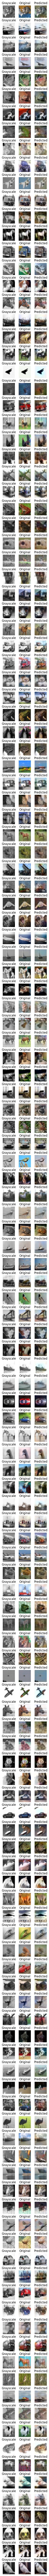

In [12]:
# Define the number of samples to generate
n_samples = 150
# Generate colorized versions of the first n_samples grayscale images in the test set
Y_hat = generator(X_test[:n_samples])

# Define the number of rows in the grid, which is equal to the number of samples
num_rows = len(Y_hat)

# Define the number of columns in the grid and the size of each image
num_cols = 3  # Number of columns in the grid
img_size = 1  # Size of each image in the grid

# Create a grid of subplots with num_rows rows and num_cols columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * img_size, num_rows * img_size))
fig.subplots_adjust(hspace=0.3, wspace=0.1)  # Adjust spacing between subplots

# Loop over the grayscale images, original color images, and colorized images
for row, (x, y, y_hat) in enumerate(zip(X_test[:n_samples], Y_test[:n_samples], Y_hat)):

    # Convert the original color image from Lab to RGB
    orig_lab = np.dstack((x, y * 128))
    orig_rgb = lab2rgb(orig_lab)

    # Convert the grayscale image from Lab to RGB
    grayscale_lab = np.dstack((x, np.zeros((IMAGE_SIZE, IMAGE_SIZE, 2))))
    grayscale_rgb = lab2rgb(grayscale_lab)

    # Convert the colorized image from Lab to RGB
    predicted_lab = np.dstack((x, y_hat * 128))
    predicted_rgb = lab2rgb(predicted_lab)

    # Display the grayscale image in the first column of the current row
    ax = axes[row, 0]  # Get the appropriate axis for the current subplot
    ax.axis('off')  # Turn off axis labels
    ax.imshow(grayscale_rgb)
    ax.set_title('Grayscale')

    # Display the original color image in the second column of the current row
    ax = axes[row, 1]  # Move to the next column for original RGB
    ax.axis('off')
    ax.imshow(orig_rgb)
    ax.set_title('Original')

    # Display the colorized image in the third column of the current row
    ax = axes[row, 2]  # Move to the next column for predicted colorized image
    ax.axis('off')
    ax.imshow(predicted_rgb)
    ax.set_title('Predicted')

    # Print the current row number to the console
    sys.stdout.flush()
    sys.stdout.write('\r{} / {}'.format(row + 1, num_rows))

# Hide empty subplots if any
for ax_row in axes:
    for ax in ax_row:
        if not ax.has_data():
            ax.axis('off')

# Adjust the padding between subplots
plt.tight_layout(pad=0.5)
# Save the figure as an image file
plt.savefig(os.path.join(WORKDIR, 'results', 'image_grid.png'))
# Display the figure
plt.show()

## Save the Generator and Discriminator Trained Models

In [13]:
# Save the checkpoints of the models and optimizers so that they can be loaded later
# Save the generator model in the SavedModel format
tf.saved_model.save(generator, os.path.join(WORKDIR, "generator-saved-model"))

# Save the discriminator model in the SavedModel format
tf.saved_model.save(discriminator, os.path.join(WORKDIR, "disciminator-saved-model"))

INFO:tensorflow:Assets written to: /GANWorkspace/generator-saved-model\assets


INFO:tensorflow:Assets written to: /GANWorkspace/generator-saved-model\assets


INFO:tensorflow:Assets written to: /GANWorkspace/disciminator-saved-model\assets


INFO:tensorflow:Assets written to: /GANWorkspace/disciminator-saved-model\assets


In [ ]:
# from google.colab import files
# files.download()

# !zip -r /content/drive.zip /content/drive


  adding: content/drive/ (stored 0%)
  adding: content/drive/My Drive/ (stored 0%)
  adding: content/drive/My Drive/Colab Notebooks/ (stored 0%)
  adding: content/drive/My Drive/Colab Notebooks/Workspace/ (stored 0%)
  adding: content/drive/My Drive/Colab Notebooks/Workspace/X_test.npy (deflated 18%)
  adding: content/drive/My Drive/Colab Notebooks/Workspace/results/ (stored 0%)
  adding: content/drive/My Drive/Colab Notebooks/Workspace/results/image_grid.png (deflated 2%)
  adding: content/drive/My Drive/Colab Notebooks/Workspace/Y_test.npy (deflated 15%)
  adding: content/drive/My Drive/Colab Notebooks/Workspace/Y_train.npy (deflated 15%)
  adding: content/drive/My Drive/Colab Notebooks/Workspace/generator-saved-model/ (stored 0%)
  adding: content/drive/My Drive/Colab Notebooks/Workspace/generator-saved-model/assets/ (stored 0%)
  adding: content/drive/My Drive/Colab Notebooks/Workspace/generator-saved-model/variables/ (stored 0%)
  adding: content/drive/My Drive/Colab Notebooks/Wor